1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


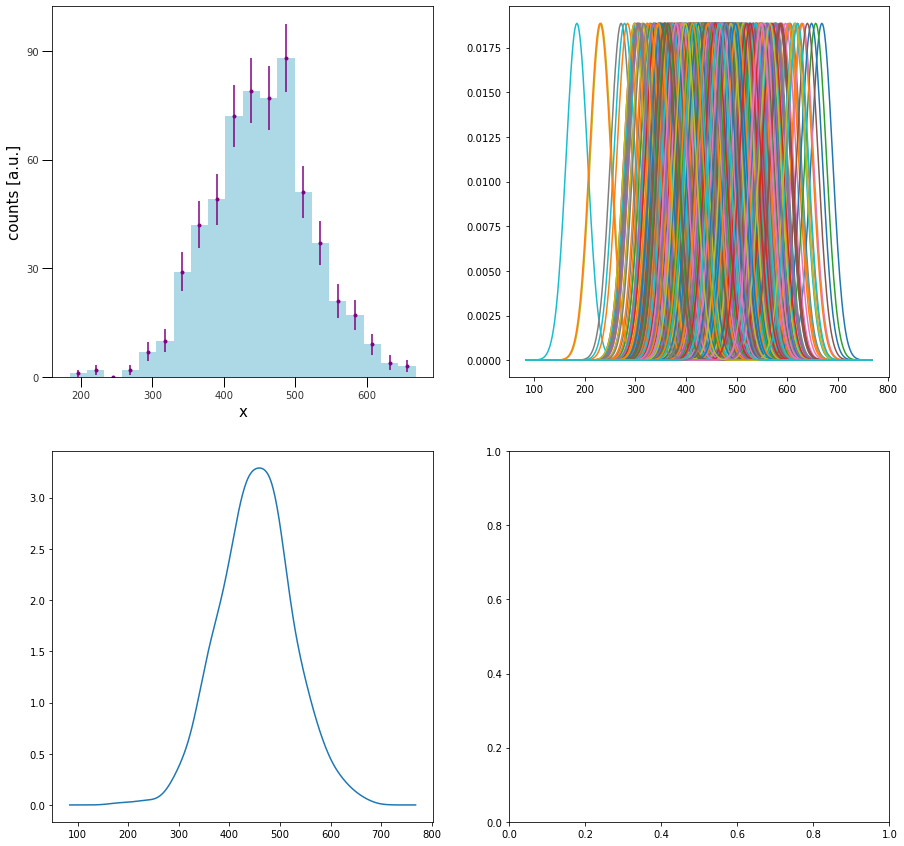

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import math as m

import scipy
from scipy.stats import norm


%matplotlib inline 

mean=450
std_dev=70
N=600

x=np.random.normal(mean, std_dev, N)


fig, axs = plt.subplots(2,2,figsize=(15,15))
rangex=np.linspace(x.min(), x.max(), 21)
axs[0,0].hist(x, bins=rangex, color='lightblue')
axs[0,0].set_xlabel('x', fontsize=15)
axs[0,0].set_ylabel('counts [a.u.]',fontsize= 15)
#ax1.set_xlim(200,700)

axs[0,0].tick_params(which='both', width=1.0, length=10, labelsize=10, labelcolor='0.20')
axs[0,0].yaxis.set_major_locator(ticker.MaxNLocator(4))

number,bin_edges = np.histogram(x,rangex) #histogram with 20 bins

err_a=[m.sqrt(n) for n in number]
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
axs[0,0].errorbar( bin_centres, number, yerr=err_a, fmt='.', color='purple')


sigma =1.06*x.std()*pow(N,-1/5)
ranx=np.arange(min(x)-100,max(x)+100,2)
gaussiane=[norm.pdf(ranx, m, sigma) for m in x]

for i in gaussiane:
    axs[0,1].plot(ranx,i)
    
somme=np.sum(gaussiane,axis=0)

#integral of histogram is 600=sum(number)

#normalize
int_hist=sum(number)
int_somme=scipy.integrate.trapz(somme,ranx)

somme=[i*int_hist/int_somme for i in somme]

axs[1,0].plot(ranx,somme)

plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-18 14:23:05--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2020-11-18 14:23:05--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc53a9e125c9c633556d934b04fb.dl.dropboxusercontent.com/cd/0/inline/BDbRcg1-veh-H4FHgJZPTnlpYoEFd8lKn6UE4iJGrmJqhmB4o66Uko9tmRwhmlCcQ89waksq2npAoKNDkTk6tBn1W0Cu9SIWUyHUF0_ghkoFzg/file# [following]
--2020-11-18 14:23:06--  https://uc53a9e125c9c633556d934b04fb.dl.dropboxusercontent.com/cd/0/inline/BDbRcg1-veh-H4FHgJZPTnlpYoEFd8lKn6UE4iJGrmJqhmB4o66Uko9tmRwhmlCcQ89waksq2npAoKNDkTk6tBn1W0Cu9SIWUyHUF0_

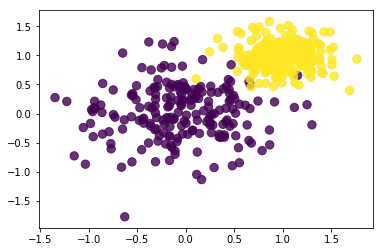

In [74]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

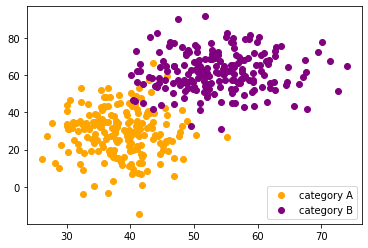

In [31]:
import numpy.random as npr

%matplotlib inline 

def generator(m1,std1,m2,std2,a):

    x=np.random.normal(m1, std1, a)
    y=np.random.normal(m2, std2, a)
    
    categories=np.zeros((2,a))
    categories[0]=x
    categories[1]=y
    

    return categories

x1=generator(38,5,29,13,200)[0]
y1=generator(38,5,29,13,200)[1]
plt.scatter(x1,y1,color='orange',label='category A')

x2=generator(54,7,61,10,200)[0]
y2=generator(54,7,61,10,200)[1]
plt.scatter(x2,y2,color='purple',label='category B')

plt.legend(loc=4)
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [29]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-11-18 19:14:18--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2020-11-18 19:14:18--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfda45bad4ca15a810fcb1b05c6.dl.dropboxusercontent.com/cd/0/inline/BDdfEGTvsKmyVhK9lD2vKsXraf3I7kbF-fB-Z-cRpIsJ9Z6NoeQHgiwKK-XnEPaj6zYl_AORKfdas2fmTmzamdnbEBFEhFt-XjzereThdnmz0g/file# [following]
--2020-11-18 19:14:19--  https://ucfda45bad4ca15a810fcb1b05c6.dl.dropboxusercontent.com/cd/0/inline/BDdfEGTvsKmyVhK9lD2vKsXraf3I7kbF-fB-Z-cRpIsJ9Z6NoeQHgiwKK-XnEPaj6zYl_AORKfdas2fmTmzamdnbEBFEhFt-XjzereThdnmz0g/file
Resolving ucfda45bad4ca15a810

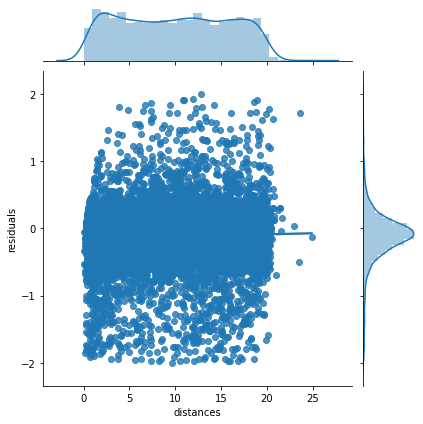

AttributeError: 'DataFrameGroupBy' object has no attribute 'loc'

In [48]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as scis
import seaborn as sns
import matplotlib.pyplot as plt

data=np.load('residuals_261.npy',allow_pickle=True)

df = pd.DataFrame(data.item(),columns=["residuals", "distances"])

df = df[np.abs(df['residuals'])<2]

slope, intercept, r_value, p_value, std_err = scis.linregress(df)
sns.jointplot(y='residuals',x='distances', data=df,kind='reg')
plt.show()

#Fill 3 numpy arrays
#x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
#y, the mean values of the "residuals", estimated in slices (bins) of "distance"
#erry, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
#Plot the profile plot on top of the scatter plot

x_min=0
x_max=25 #not 20!
x=np.array([i+0.5 for i in range(x_min,x_max)])#25 bins
bin_edges=np.array([i for i in range(x_min,x_max+1)])

df['bins']=np.digitize(df['distances'],bin_edges)#ho associato a ciascuna distances il suo bin

df.groupby(['bins']).mean()['residuals']#.drop(['bins']).to_numpy

